In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
import copy

# load pre-SCI as CP1, post-sci at CP2

In [3]:
with open('/home/diya/Documents/rat-fes/data/pickles/3-meepo_regular_923__session.pkl', 'rb') as inp: #YOUR PATH HERE
    cp1 = pickle.load(inp)
    
with open('/home/diya/Documents/rat-fes/data/pickles/3-results-injured-meepolemons1004_meepo_session.pkl', 'rb') as inp: #YOUR PATH HERE
    cp2 = pickle.load(inp)

# comparing forelimb kinematics pre and post sci

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
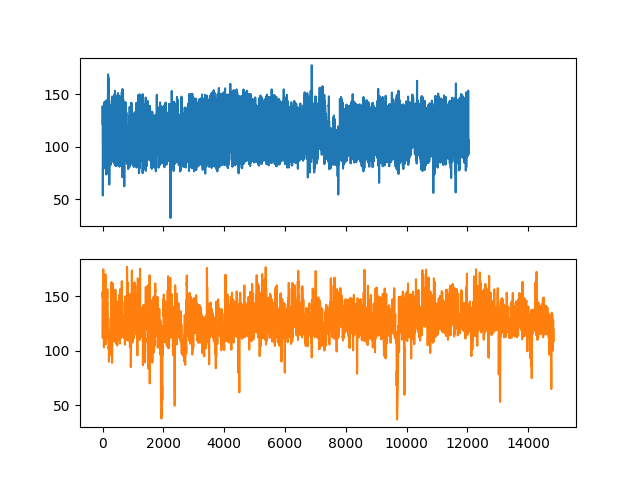

In [11]:
cp1_forelimb = np.vstack(cp1.data['angles'])[:,6]
cp2_forelimb = np.vstack(cp2.data['angles'])[:,6]

fig0 , (ax01, ax02) = plt.subplots(2,1, sharex=True)
ax01.plot(cp1_forelimb)
ax02.plot(cp2_forelimb, color='tab:orange')

# decoding forelimb just with wiener filter
adding PCA doesn't help either

0.3470000000000001
-0.005
num dims_27.0, vaf=-0.002


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
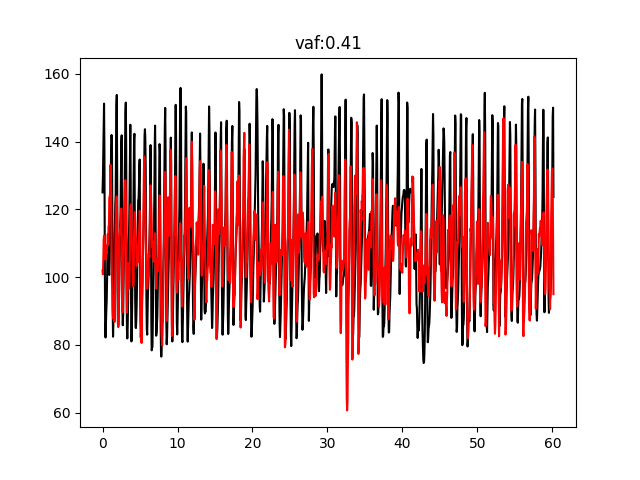

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
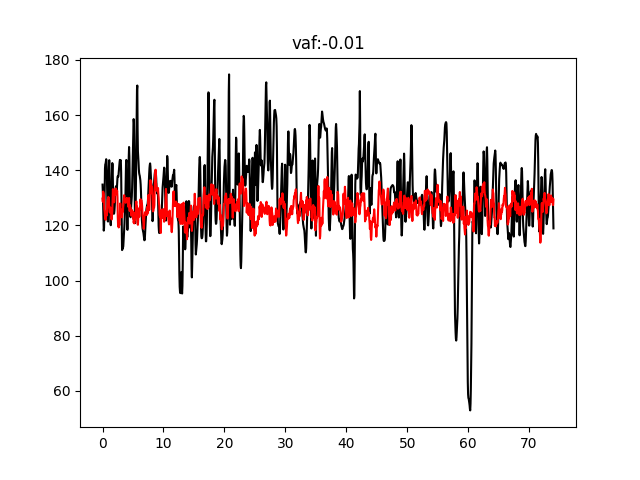

In [18]:
cp1_h, cp1_vaf, cp1_testx, cp1_testy = cp1.decode_angles()
cp2_h, cp2_vaf, cp2_testx, cp2_testy = cp2.decode_angles()

plot_wiener_filter_predic(cp1_testx, cp1_testy[:,6], cp1_h[:,6])
plot_wiener_filter_predic(cp2_testx, cp2_testy[:,6], cp2_h[:,6])
print(np.average(cp1_vaf, 1)[6])
print(np.average(cp2_vaf, 1)[6])

nada, cp2_pca_vaf, nadax, nada = cp2.decode_angles(X=cp2.apply_PCA())
temp = np.average(cp2_pca_vaf,1)[6]
print(f'num dims_{nadax.shape[1]/10}, vaf={temp}')

# lets try aligning pre and post SCI forelimb

In [19]:
my_cca = CCAProcessor(cp1, cp2, limbfoot_angle=6, align=0)

should be good to align
(1450, 32)
(1450, 7)
(1450, 32)
(1450, 7)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
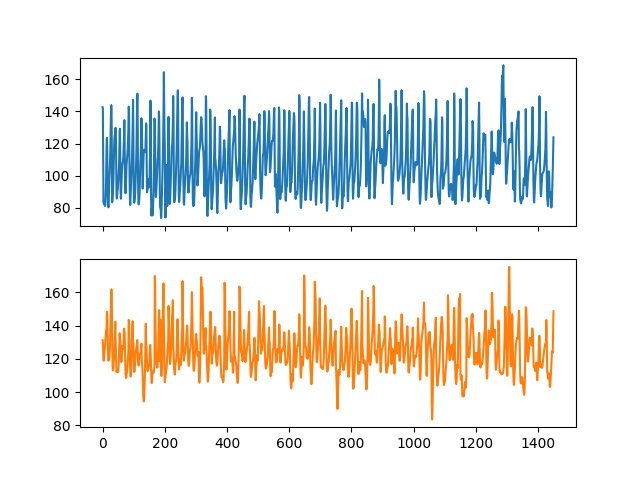

In [20]:
cp1_forelimb_aligned = my_cca.data['cp1']['proc_y'][:,6]
cp2_forelimb_aligned = my_cca.data['cp2']['proc_y'][:,6]

fig1, (ax11, ax12) = plt.subplots(2,1, sharex=True)
ax11.plot(cp1_forelimb_aligned)
ax12.plot(cp2_forelimb_aligned, color='tab:orange')

# training alignment decoder

In [30]:
transformer, wpost, ywpost = my_cca.apply_ridge()

dim0 corr is 0.28
dim1 corr is 0.26
dim2 corr is 0.25
(1450, 32) (1450, 7)
initial_scoring is : -0.07
new_scoring is: 0.25


# applying trained decoder to entire SCI dataset  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
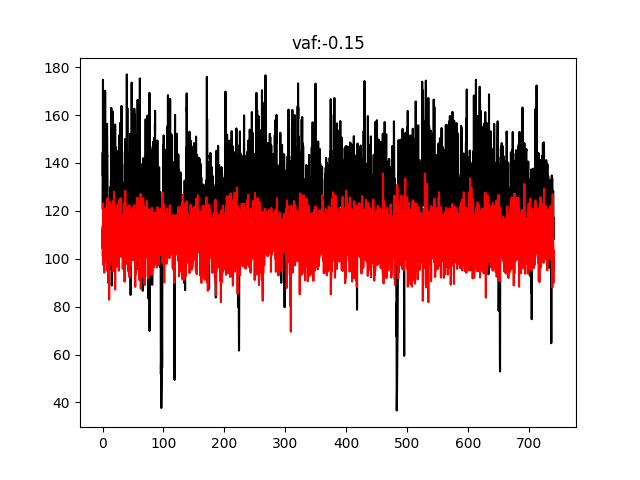

In [38]:
scaler = StandardScaler()
full_x = cp2.data['rates']
full_y = cp2.data['angles']

aligned_full_x = []
scaler.fit(np.vstack(full_x))
for x in full_x:
    temp_x = scaler.transform(x)
    aligned_full_x.append(my_cca.quick_cca(temp_x, transformer))

aligned_full_x_format, full_y_format = cp2.stitch_and_format(aligned_full_x, full_y)
full_predic = test_wiener_filter(aligned_full_x_format, wpost)
plot_wiener_filter_predic(aligned_full_x_format, full_y_format[:,6], wpost[:,6]) 

In [35]:
aligned_full_x_format.shape

(14801, 7)

0.06


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
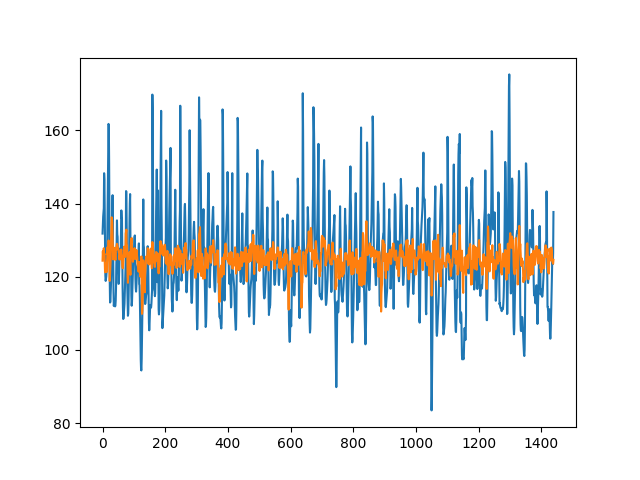

In [105]:
fig, ax = plt.subplots()
ax.plot(proc_y_format[:,6])
ax.plot(ywpost_adjusted[:,6])

print(vaf(proc_y_format[:,6], ywpost_adjusted[:,6]))



In [92]:
aligned_raw_x_format, raw_y_format = my_cca.cp2.stitch_and_format(aligned_raw_x, raw_y)

-0.14


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
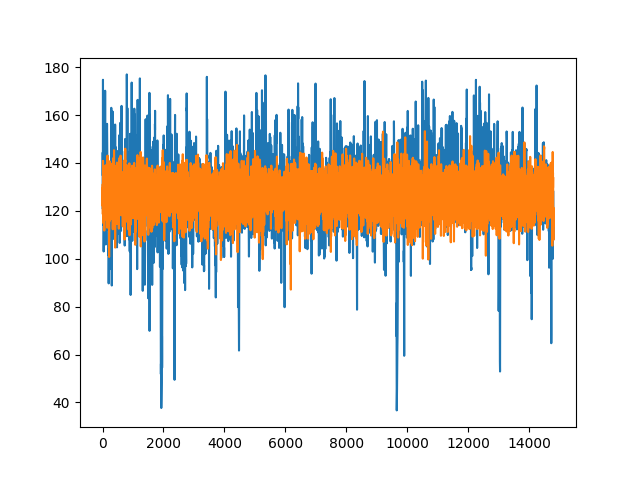

In [93]:
predic = test_wiener_filter(aligned_raw_x_format, wpost)
fig, ax = plt.subplots()
predic_adjusted = predic + (np.mean(raw_y_format[:,6]) - np.mean(predic[:,6]))
ax.plot(raw_y_format[:,6])
ax.plot(predic_adjusted[:,6])

print(vaf(raw_y_format[:,6], predic_adjusted[:,6]))

In [47]:
kin1 = my_cca.data['cp1']['proc_y']
kin2 = my_cca.data['cp2']['proc_y']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
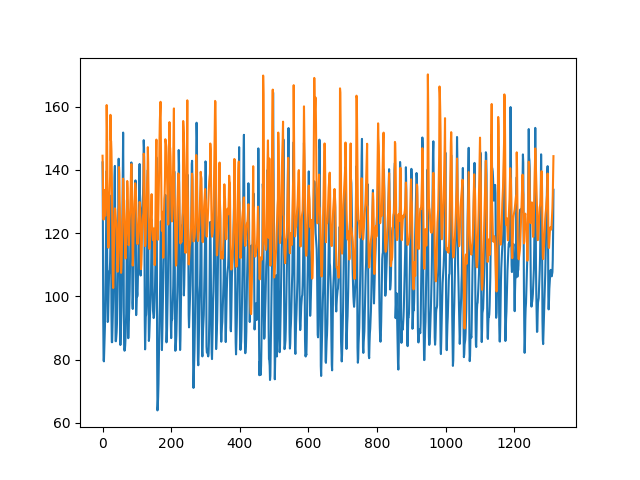

In [48]:
fig, ax=plt.subplots()
ax.plot(kin1[:,6])
ax.plot(kin2[:,6])

In [52]:
diya.shape

(1315, 32)

In [58]:
diya_format, y_format = format_data(diya, kin2)

In [59]:
predic = test_wiener_filter(diya_format, h)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
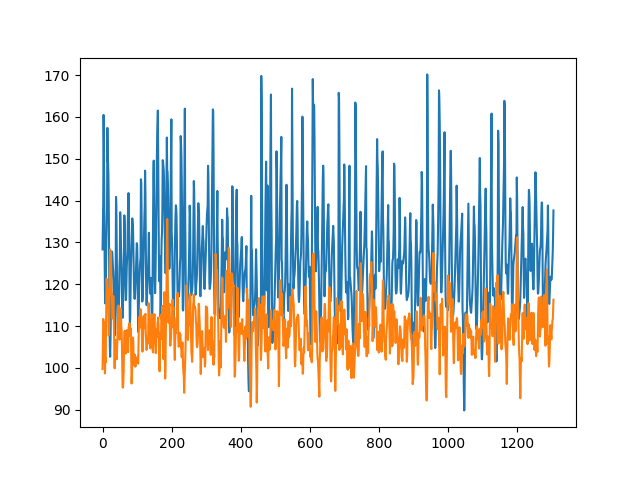

In [60]:
fig, ax = plt.subplots()
ax.plot(y_format[:,6])
ax.plot(predic[:,6])